In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as st
import warnings
warnings.filterwarnings("ignore")
sns.set(rc={"figure.figsize":(15,6)})
pd.pandas.set_option("display.max_columns",None)
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,BatchNormalization,Dropout
from tensorflow.keras.applications.vgg16 import VGG16

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d prathamgrover/brain-tumor-classification

 88% 76.0M/86.8M [00:00<00:00, 110MB/s]
100% 86.8M/86.8M [00:01<00:00, 80.7MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/brain-tumor-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.9 MB/s eta 0:00:00


In [7]:
import keras_tuner
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import cv2

In [8]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow import keras

In [9]:
IMG_SIZE=[224,224]

In [10]:
train_path='/content/Training'
test_path='/content/Testing'

In [11]:
import os
print(os.listdir('/content/Training'))
print(os.listdir('/content/Testing'))

['pituitary_tumor', 'meningioma_tumor', 'no_tumor', 'glioma_tumor']
['pituitary_tumor', 'meningioma_tumor', 'no_tumor', 'glioma_tumor']


In [12]:
#view image
# Load the image
image_path = "/content/Training/meningioma_tumor/m (10).jpg"
image = cv2.imread(image_path)
# Check the shape of the image
image_shape = image.shape
print("Image Shape:", image_shape)

Image Shape: (512, 512, 3)


In [13]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMG_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [14]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [15]:
#to find how many classification of images are
folders=glob('/content/Training/*')
folders

['/content/Training/pituitary_tumor',
 '/content/Training/meningioma_tumor',
 '/content/Training/no_tumor',
 '/content/Training/glioma_tumor']

In [16]:
x=Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)

In [17]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [20]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/Training',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/Testing',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [21]:
training_set.directory

'/content/Training'

In [22]:
class_indices = training_set.class_indices
class_counts = {class_name: len(os.listdir(os.path.join(training_set.directory, class_name))) for class_name in class_indices.keys()}
print(class_counts)

{'glioma_tumor': 826, 'meningioma_tumor': 822, 'no_tumor': 395, 'pituitary_tumor': 827}


In [27]:
from sklearn.utils.class_weight import compute_class_weight

# Assuming you have a target variable named 'y' in your training_set
y = training_set.classes
y
# Assuming you have a target variable named 'y' in your training_set
y = training_set.classes

# Calculate class weights manually
total_samples = len(y)
class_counts = np.bincount(y)
class_weights = total_samples / (len(np.unique(y)) * class_counts)

class_weights_dict = dict(zip(np.unique(y), class_weights))


In [33]:
class_weights_dict

{0: 0.8686440677966102,
 1: 0.8728710462287105,
 2: 1.8164556962025316,
 3: 0.8675937122128174}

In [29]:
model

In [41]:
# now Compile the model
model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = "Adam",
    metrics = ["accuracy"]
)


In [42]:
# Fit the model with class weights
history = model.fit(
    training_set,
    validation_data=test_set,
    epochs=10,  # Adjust the number of epochs as needed
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set),
    class_weight=class_weights_dict
)

Epoch 1/10
90/90 [==============================] - 43s 470ms/step - loss: 0.2805 - accuracy: 0.8847 - val_loss: 1.6210 - val_accuracy: 0.7183
Epoch 2/10
90/90 [==============================] - 42s 468ms/step - loss: 0.1926 - accuracy: 0.9240 - val_loss: 1.8611 - val_accuracy: 0.7360
Epoch 3/10
90/90 [==============================] - 41s 455ms/step - loss: 0.1855 - accuracy: 0.9296 - val_loss: 1.9121 - val_accuracy: 0.7589
Epoch 4/10
90/90 [==============================] - 41s 454ms/step - loss: 0.1676 - accuracy: 0.9362 - val_loss: 1.6574 - val_accuracy: 0.7284
Epoch 5/10
90/90 [==============================] - 42s 464ms/step - loss: 0.1626 - accuracy: 0.9307 - val_loss: 1.9586 - val_accuracy: 0.7360
Epoch 6/10
90/90 [==============================] - 42s 466ms/step - loss: 0.1302 - accuracy: 0.9481 - val_loss: 2.1735 - val_accuracy: 0.7513
Epoch 7/10
90/90 [==============================] - 42s 464ms/step - loss: 0.1404 - accuracy: 0.9446 - val_loss: 2.0693 - val_accuracy: 0.7437

#ploting loss Graph

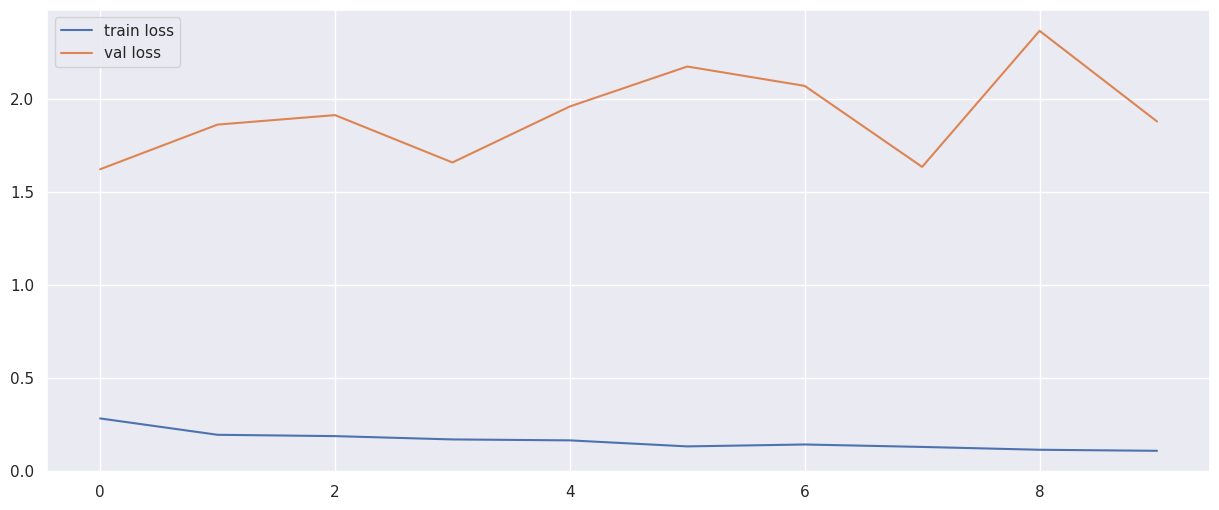

<Figure size 1500x600 with 0 Axes>

In [44]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

#plotting accuracy graph

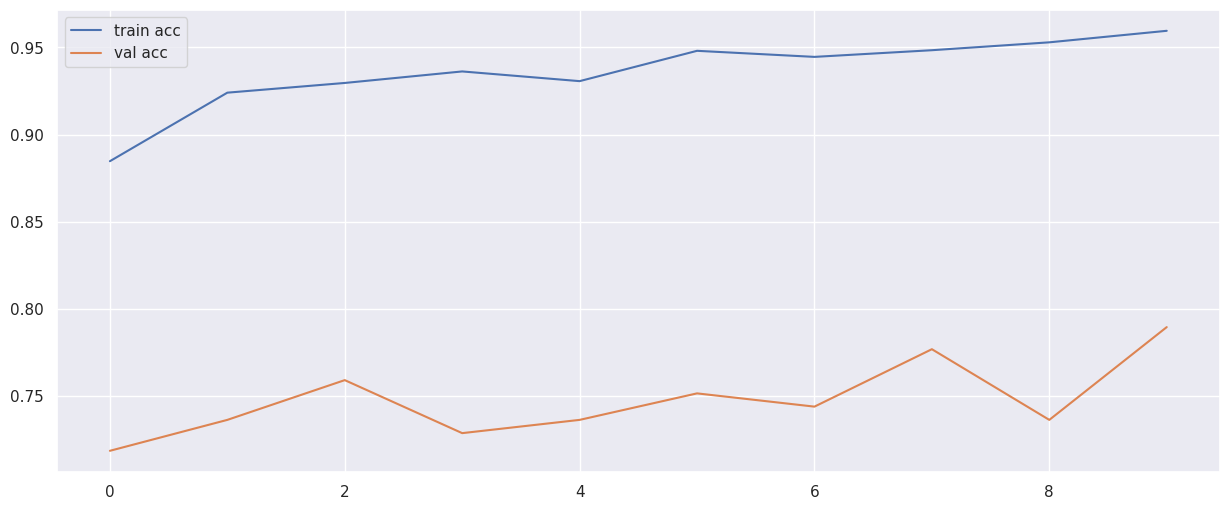

<Figure size 1500x600 with 0 Axes>

In [46]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')


# Prediction

In [70]:
test_image=cv2.imread('/content/Testing/pituitary_tumor/image(1).jpg')
test_image

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8)

In [71]:
test_image.shape

(512, 488, 3)

(-0.5, 487.5, 511.5, -0.5)

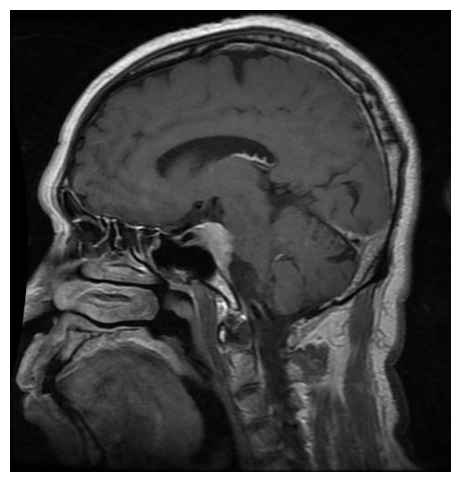

In [72]:
plt.imshow(test_image)
plt.axis("off")

In [73]:
test_image_resized = cv2.resize(test_image,(224,224))
test_image_resized.shape

(224, 224, 3)

In [74]:
predicted_class[0]

2